In [2]:
import os
import json
import numpy as np
from collections import defaultdict
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset #load_dataset from Huggingface
from scipy import stats

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
HF_LANG_DICT = {'estonian': 'et', 
                 'haitiancreole': 'ht', 
                 'indonesian': 'id',
                 'italian': 'it',
                 'quechua': 'qu',
                 'swahili': 'sw',
                 'tamil': 'ta',
                 'thai': 'th',
                 'turkish': 'tr',
                 'vietnamese': 'vi',
                 'chinese': 'zh',
                 'englishestonian': 'translation-et',
                 'englishhaitiancreole': 'translation-ht',
                 'englishindonesian': 'translation-id',
                 'englishitalian': 'translation-it',
                 'englishquechua': 'translation-sw',
                 'englishswahili': 'translation-sw',
                 'englishtamil': 'translation-ta',
                 'englishthai': 'translation-th',
                 'englishturkish': 'translation-tr',
                 'englishvietnamese': 'translation-vi',
                 'englishchinese': 'translation-zh'}

LANG_DICT = {'estonian': 'et', 
                 'haitiancreole': 'ht', 
                 'indonesian': 'id',
                 'italian': 'it',
                 'quechua': 'qu',
                 'swahili': 'sw',
                 'tamil': 'ta',
                 'thai': 'th',
                 'turkish': 'tr',
                 'vietnamese': 'vi',
                 'chinese': 'zh',
                 'englishestonian': 'en_et',
                 'englishhaitiancreole': 'en_ht',
                 'englishindonesian': 'en_id',
                 'englishitalian': 'en_it',
                 'englishquechua': 'en_qu',
                 'englishswahili': 'en_sw',
                 'englishtamil': 'en_ta',
                 'englishthai': 'en_th',
                 'englishturkish': 'en_tr',
                 'englishvietnamese': 'en_vi',
                 'englishchinese': 'en_zh'}

LANGUAGE = ['chinese', 'haitiancreole', 'indonesian', 'italian', 'quechua', 'swahili', 'tamil', 'thai', 'turkish', 'vietnamese']
LANGUAGE_INCLUDING_ENGLISH = ['chinese', 'haitiancreole', 'indonesian', 'italian', 'quechua', 'swahili', 'tamil', 'thai', 'turkish', 'vietnamese',
                              'englishchinese', 'englishhaitiancreole', 'englishindonesian', 'englishitalian', 'englishquechua',  'englishswahili', 'englishtamil', 'englishthai', 'englishturkish', 'englishvietnamese']

In [106]:
def get_accuracy_outputs(lang, dataset='xcopa', model='Llama3.1', mode='normalized', shot=5):
    model_dict = {'Llama3.1': 'meta-llama__Llama-3.1-8B'}
    hf_lang_code = HF_LANG_DICT[lang]
    lang_code = LANG_DICT[lang]
    model_code = model_dict[model]
    hf = load_dataset("xcopa", hf_lang_code)
    label = hf['test']['label']
    answer = []
    for i in range(len(label)):
        answer.append(label[i])
    
    if mode == 'normalized':
        accuracy_data_path = f'../accuracy_outputs/{model}/{dataset}_normalized_{shot}shot/{lang_code}/{model_code}/'
    else:
        accuracy_data_path = f'../accuracy_outputs/{model}/{dataset}_unnormalized_{shot}shot/{lang_code}/{model_code}/'
    # Find the .jsonl file in the directory
    jsonl_file = [f for f in os.listdir(accuracy_data_path) if f.endswith('.jsonl')][0]
    file_path = os.path.join(accuracy_data_path, jsonl_file)
    # Read the jsonl file line by line
    accuracy_results = []
    with open(file_path, 'r') as f:
        for line in f:
            accuracy_results.append(json.loads(line))

    resps = [item['resps'] for item in accuracy_results]
    accuracy = [item['acc'] for item in accuracy_results]
    score_diff = []
    for i in range(len(answer)):
        if answer[i]==0:
            score_diff.append(float(resps[i][0][0][0]) - float(resps[i][1][0][0]))
        if answer[i]==1:
            score_diff.append(float(resps[i][1][0][0]) - float(resps[i][0][0][0]))
    return score_diff, accuracy

In [107]:
def compute_confusion_matrix(correct_eng, incorrect_eng, correct_lang, incorrect_lang):
    TP = len(set(correct_eng) & set(correct_lang))
    FN = len(set(incorrect_eng) & set(correct_lang))
    FP = len(set(correct_eng) & set(incorrect_lang))
    TN = len(set(incorrect_eng) & set(incorrect_lang))
    
    return np.array([[TP, FN], [FP, TN]])

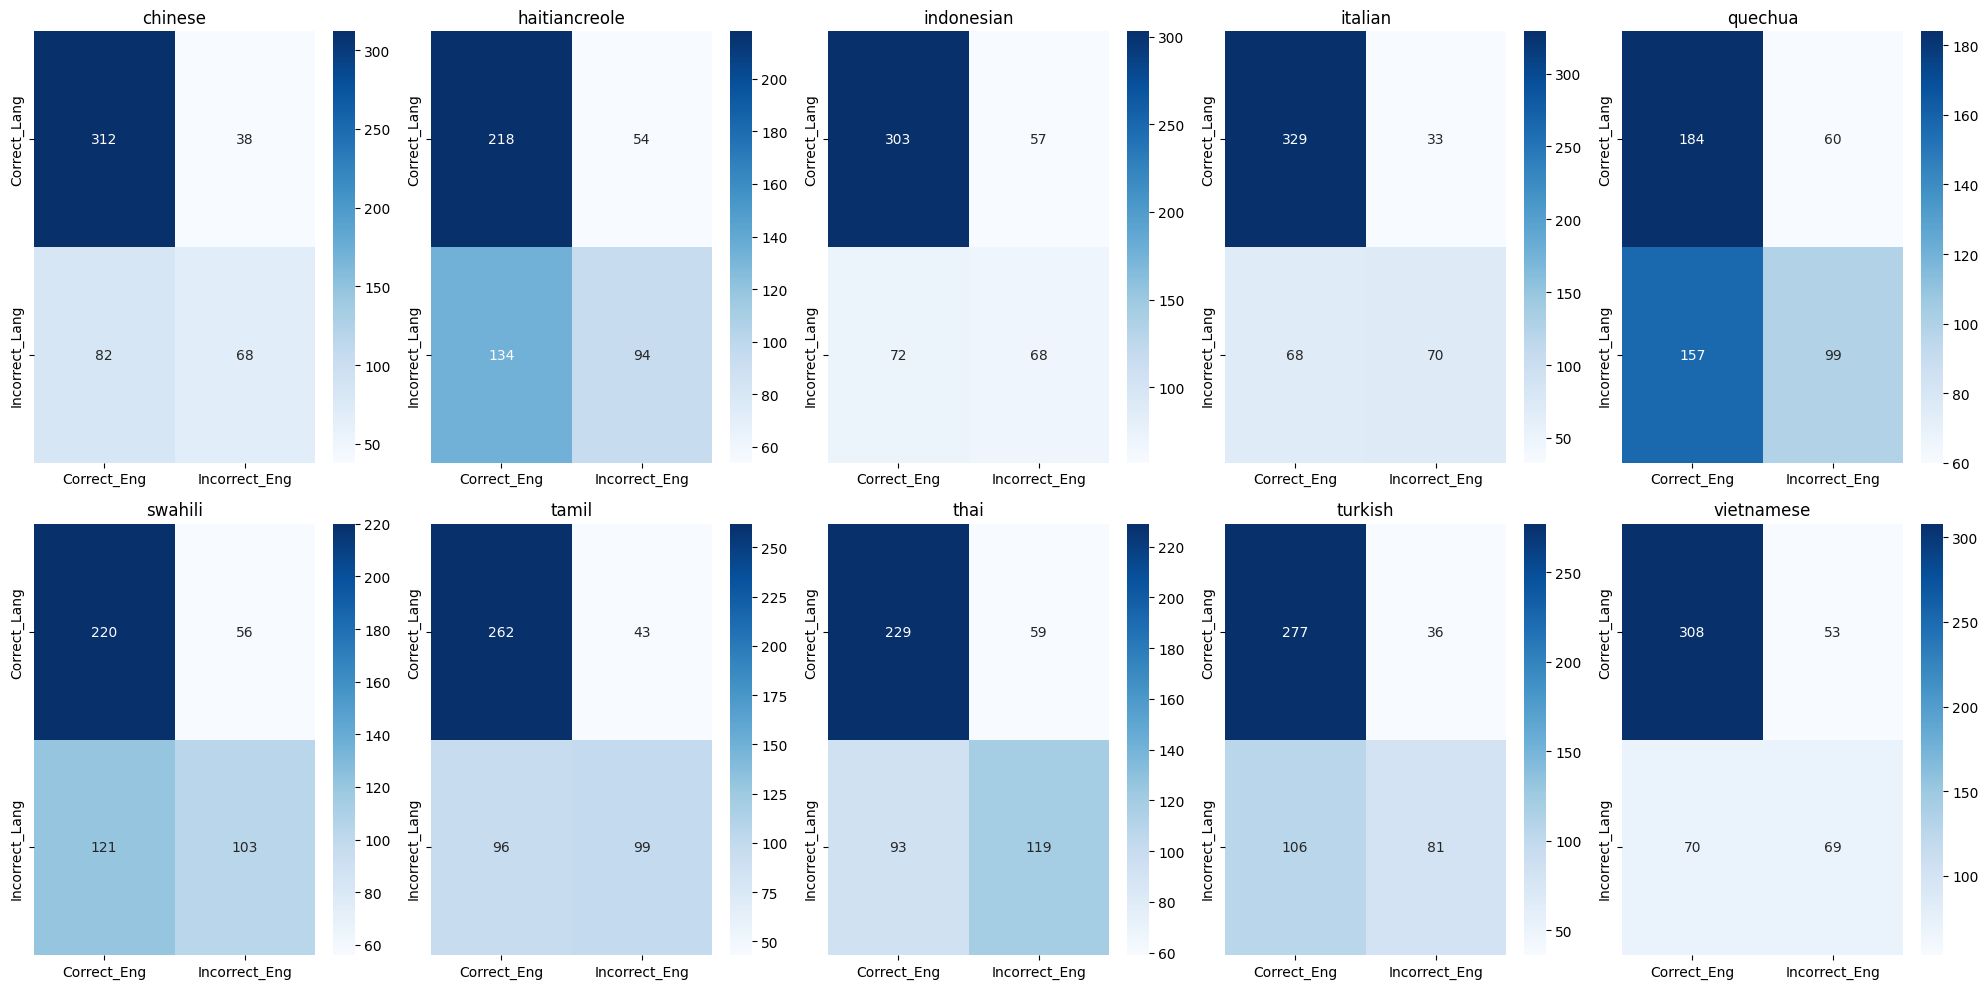

In [132]:
acc_dict = defaultdict(dict)
score_diff_dict = defaultdict(dict)

conf_matrices = defaultdict(dict)

for lang in LANGUAGE:
    score_diff_dict['english'+lang],acc_dict['english'+lang]  = get_accuracy_outputs('english'+lang, 'xcopa', 'Llama3.1', mode='unnormalized', shot=0)
    score_diff_dict[lang],acc_dict[lang]  = get_accuracy_outputs(lang, 'xcopa', 'Llama3.1', mode='unnormalized', shot=0)
    correct_id_eng = [i for i,acc in enumerate(acc_dict['english'+lang]) if acc==1]
    incorrect_id_eng = [i for i,acc in enumerate(acc_dict['english'+lang]) if acc==0]
       
    correct_id_lang = [i for i,acc in enumerate(acc_dict[lang]) if acc==1]
    incorrect_id_lang = [i for i,acc in enumerate(acc_dict[lang]) if acc==0]

    # Example language data (Replace with actual lists)
    conf_matrices[lang] = compute_confusion_matrix(correct_id_eng, incorrect_id_eng, correct_id_lang, incorrect_id_lang)
    
    correct_eng_incorrect_lang_ids = list(set(correct_id_eng) & set(incorrect_id_lang))
    correct_eng_correct_lang_ids = list(set(correct_id_eng) & set(correct_id_lang))

# Plot multiple confusion matrices
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 rows, 5 columns

for ax, (lang, matrix) in zip(axes.flat, conf_matrices.items()):
    
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Correct_Eng", "Incorrect_Eng"], 
                yticklabels=["Correct_Lang", "Incorrect_Lang"], ax=ax)
    ax.set_title(lang)

    plt.tight_layout()
plt.show()   

In [133]:
def plot_DALI(dataset, lang, model):
    DAS_path = f'../alignment_outputs/{model}/{dataset}_dali/DALI_{lang}_lasttoken.json'
    with open(DAS_path) as f:
        lang_DAS = json.load(f)
    return lang_DAS

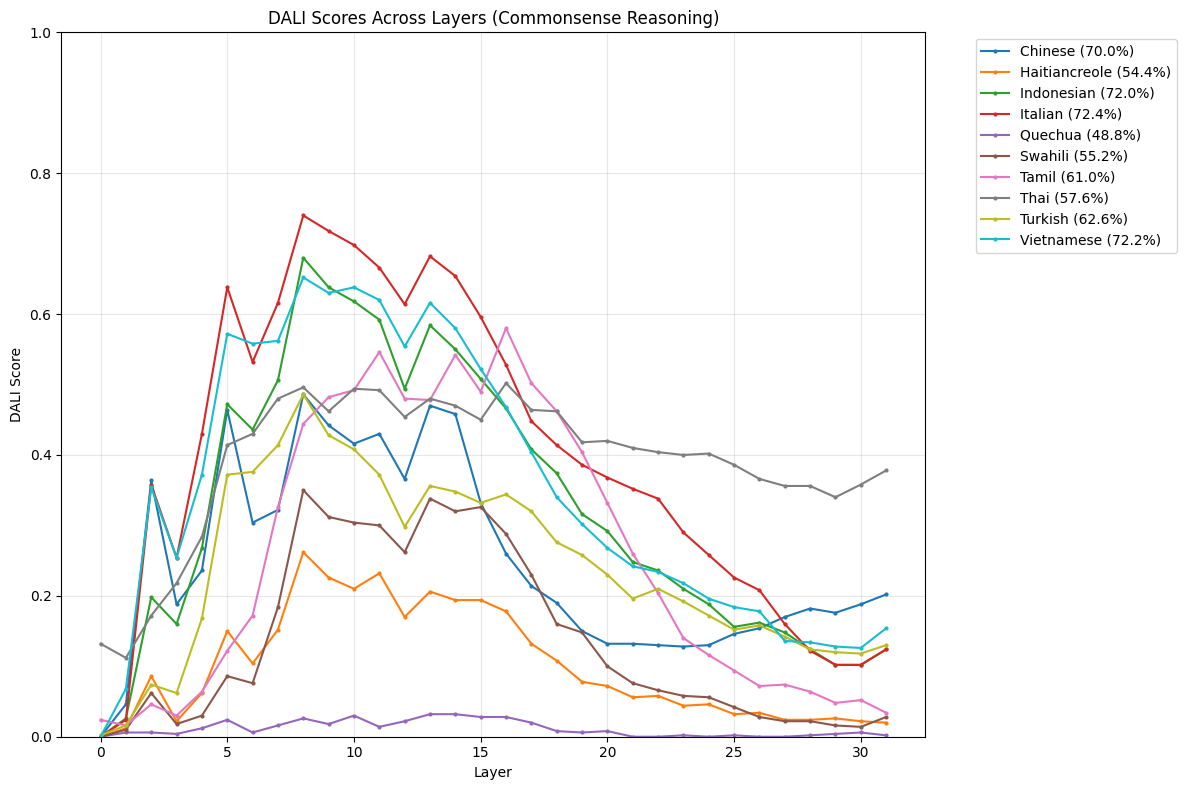


Languages ranked by maximum DALI score:
1. Italian: 0.740
2. Indonesian: 0.680
3. Vietnamese: 0.652
4. Tamil: 0.580
5. Thai: 0.502
6. Chinese: 0.486
7. Turkish: 0.486
8. Swahili: 0.350
9. Haitiancreole: 0.262
10. Quechua: 0.032


In [136]:
# Calculate accuracies and get DAS scores for each language
accuracies = {}
max_das_scores = {}
all_das_avgs = {}

fig, ax = plt.subplots(figsize=(12, 8))

for lang in LANGUAGE:
    # Calculate accuracy
    accuracies[lang] = (sum(acc_dict[lang])/len(acc_dict[lang])) * 100
    # Get DAS data for this language
    lang_DAS = plot_DALI('xcopa', lang, 'Llama3.1')
    
    lang_DAS = {int(outer_k): {int(inner_k): v for inner_k, v in inner_v.items()} 
                for outer_k, inner_v in lang_DAS.items()}
    
    
    # Calculate average DAS across all samples for each layer
    layer_avgs = []
    for layer in range(32):
        layer_scores = [lang_DAS[sample][layer] for sample in lang_DAS.keys()]
        layer_avgs.append(np.mean(layer_scores))
    
    all_das_avgs[lang] = layer_avgs
    max_das_scores[lang] = np.max(layer_avgs)
    
    # Plot line with accuracy in legend
    ax.plot(range(32), layer_avgs, 
            label=f'{lang.capitalize()} ({accuracies[lang]:.1f}%)', 
            marker='o', markersize=2)

ax.set_xlabel('Layer')
ax.set_ylabel('DALI Score')
ax.set_title('DALI Scores Across Layers (Commonsense Reasoning)')
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim(0,1)

plt.tight_layout()
plt.show()

# Rank languages by maximum DAS score
ranked_languages = sorted(max_das_scores.items(), key=lambda x: x[1], reverse=True)
print("\nLanguages ranked by maximum DALI score:")
for i, (lang, score) in enumerate(ranked_languages, 1):
    print(f"{i}. {lang.capitalize()}: {score:.3f}")

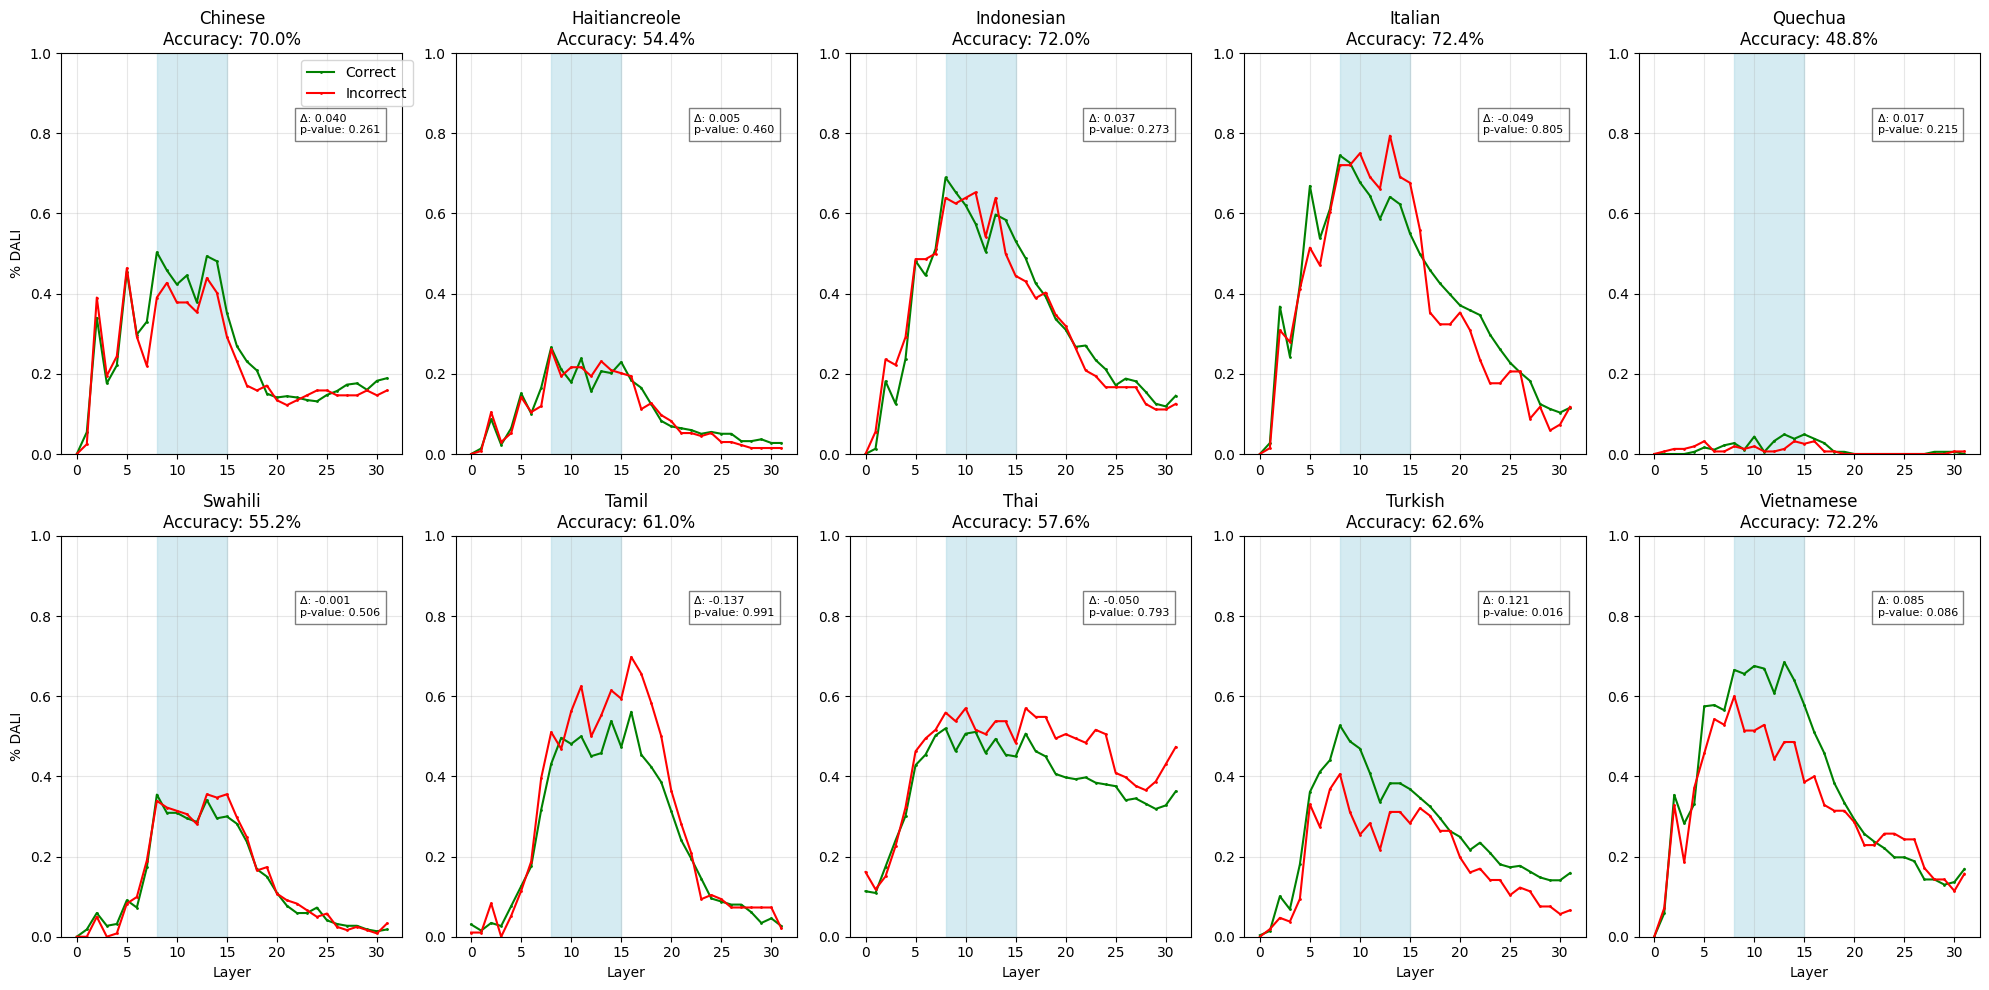

In [137]:
# Calculate accuracies for each language
from statsmodels.stats.weightstats import ztest

accuracies = {lang: (sum(acc_dict[lang])/len(acc_dict[lang])) * 100 for lang in LANGUAGE}

# Create a figure with subplots (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

# Flatten axes for easier iteration
axes = axes.flatten()

for idx, (lang, ax) in enumerate(zip(LANGUAGE, axes)):
    # Get accuracy data for this language
    correct_id_eng = [i for i,acc in enumerate(acc_dict['english'+lang]) if acc==1]
    incorrect_id_eng = [i for i,acc in enumerate(acc_dict['english'+lang]) if acc==0]
    correct_id_lang = [i for i,acc in enumerate(acc_dict[lang]) if acc==1]
    incorrect_id_lang = [i for i,acc in enumerate(acc_dict[lang]) if acc==0]
    
    correct_eng_incorrect_lang_ids = list(set(correct_id_eng) & set(incorrect_id_lang))
    correct_eng_correct_lang_ids = list(set(correct_id_eng) & set(correct_id_lang))
    incorrect_eng_correct_lang_ids = list(set(incorrect_id_eng) & set(correct_id_lang))
    incorrect_eng_incorrect_lang_ids = list(set(incorrect_id_eng) & set(incorrect_id_lang))

    
    # Get DAS data for this language
    lang_DAS = plot_DALI('xcopa', lang, 'Llama3.1')
    lang_DAS = {int(outer_k): {int(inner_k): v for inner_k, v in inner_v.items()} 
                for outer_k, inner_v in lang_DAS.items()}

    # Calculate averages for both cases
    correct_list = defaultdict(list)
    incorrect_list = defaultdict(list)

    for item in correct_eng_correct_lang_ids:
        for layer in range(32):
            correct_list[layer].append(lang_DAS[item][layer])

    for item in correct_eng_incorrect_lang_ids:
        for layer in range(32):
            incorrect_list[layer].append(lang_DAS[item][layer])
        
    correct_mean = []
    incorrect_mean = []

    for k,v in correct_list.items():
        correct_mean.append(np.mean(v))

    for k,v in incorrect_list.items():
        incorrect_mean.append(np.mean(v))

    max_index_correct = np.argmax(correct_mean)
    max_index_incorrect = np.argmax(incorrect_mean)

    
        
    delta = correct_mean[max_index_correct] - incorrect_mean[max_index_incorrect]
    z, p_value = ztest(correct_list[max_index_correct], incorrect_list[max_index_incorrect], alternative="larger")


    
    # Plot lines for this language
    layers = list(range(32))
    ax.plot(layers, [correct_mean[l] for l in layers], 
            label='Correct', marker='o', color='green', markersize=1)
    ax.plot(layers, [incorrect_mean[l] for l in layers], 
            label='Incorrect', color = 'red', marker='o', markersize=1)
    
    
    annotation_text = f'Δ: {delta:.3f}\np-value: {p_value:.3f}'
    ax.annotate(annotation_text, xy=(0.7, 0.8), xycoords='axes fraction', fontsize=8,
                bbox=dict(facecolor='white', alpha=0.5))
    
    ax.set_ylim(0,1)
    
    # Add title with accuracy
    ax.set_title(f'{lang.capitalize()}\nAccuracy: {accuracies[lang]:.1f}%')
    ax.grid(True, alpha=0.3)
    ax.axvspan(8, 15, color='lightblue', alpha=0.5)
    
    # Only add x and y labels for the bottom row and leftmost column
    if idx >= 5:  # Bottom row
        ax.set_xlabel('Layer')
    if idx % 5 == 0:  # Leftmost column
        ax.set_ylabel('% DALI')
    
    # Add legend only for the first subplot
    if idx == 0:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper right')

plt.tight_layout()
plt.show()

In [102]:
print(acc_dict['chinese'])
DALI = plot_DALI('xcopa', 'chinese', 'Llama3.1')

[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0,